In [1]:
import SimpleITK as sitk
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

def load_x(path):# load x 3d image
    img, origin, spacing = load_itk(path)
    
    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    #resize image
    resized_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    print(resized_img.shape)
    normalized_img = ((resized_img - np.min(resized_img)) / (np.max(resized_img) - np.min(resized_img))) * 255
    return normalized_img

In [183]:
x = load_x('../data/Jack/images/case1.mhd')
y = load_x('../data/Jack/labeled/case1_label.mhd')

(559, 160, 160)
(559, 160, 160)


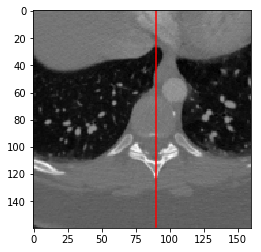

In [3]:
z = 90
plt.plot((z, z), (0, 159), '-', color='red')
plt.imshow(x[200,:,:], cmap='gray')

True

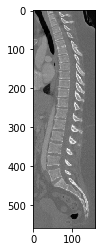

In [4]:
plt.imshow(x[:,:,z], cmap='gray')
cv2.imwrite('../darknet/data/ian/test/script.png', x[:,:,90])

In [5]:
#os.chdir('../script')

In [6]:
# YOLO predict

import subprocess
import os

origin_dir = os.getcwd()
os.chdir('../darknet')

#cmdstr = './darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_50000.weights data/ian/test/case1_97.jpg'
cmdstr = './darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_last.weights -dont_show -ext_output < {} > {} -i 1'.format('data/ian/test/script.txt', 'data/ian/test/script_result.txt')
print(cmdstr)

detect_result = subprocess.check_output(cmdstr, shell = True)

os.chdir(origin_dir)

print(detect_result)
print('== YOLO pedicted ==')

./darknet detector test cfg/ian.data cfg/yolov3-ian.cfg backup/yolov3-ian_last.weights -dont_show -ext_output < data/ian/test/script.txt > data/ian/test/script_result.txt -i 1
b''
== YOLO pedicted ==


In [51]:
# Load YOLO predict result

import re

yolo_results = []

with open('../darknet/data/ian/test/script_result.txt', 'r') as f:
    content = f.read().split('Enter Image Path:')
    print(content)
    result = content[1].split('\n')
    del result[0], result[-1]
    
    for line in result:
        yolo_results.append({
            'label': line.split(':')[0],
            #'confidence': int(re.sub("\D", "", line.split('%')[0].split(':')[1])),
            'left_x': int(re.sub("\D", "", line.split(':')[2])),
            'top_y': int(re.sub("\D", "", line.split(':')[3])),
            'center_x': int(int(re.sub("\D", "", line.split(':')[2])) + int(re.sub("\D", "", line.split(':')[4]))/2),
            'center_y': int(int(re.sub("\D", "", line.split(':')[3])) + int(re.sub("\D", "", line.split(':')[5]))/2),
            'w': int(re.sub("\D", "", line.split(':')[4])),
            'h': int(re.sub("\D", "", line.split(':')[5])),
        })

yolo_results = sorted(yolo_results, key=lambda r: r['center_y'])
        
for i in yolo_results:
    print(i)

['Total BFLOPS 65.428 \n\n seen 64 \n', ' data/ian/test/script.png: Predicted in 143.946000 milli-seconds.\nvertebrae: 100%\t(left_x:   34   top_y:  373   width:   38   height:   30)\nvertebrae: 100%\t(left_x:   35   top_y:   -0   width:   19   height:   12)\nvertebrae: 100%\t(left_x:   36   top_y:    9   width:   23   height:   18)\nvertebrae: 100%\t(left_x:   37   top_y:  406   width:   38   height:   33)\nvertebrae: 100%\t(left_x:   37   top_y:  340   width:   38   height:   31)\nvertebrae: 100%\t(left_x:   41   top_y:   25   width:   25   height:   19)\nvertebrae: 100%\t(left_x:   44   top_y:  308   width:   38   height:   31)\nvertebrae: 100%\t(left_x:   46   top_y:   42   width:   27   height:   20)\nvertebrae: 100%\t(left_x:   50   top_y:  278   width:   37   height:   31)\nvertebrae: 100%\t(left_x:   52   top_y:   58   width:   25   height:   22)\nvertebrae: 100%\t(left_x:   56   top_y:  250   width:   35   height:   30)\nvertebrae: 100%\t(left_x:   56   top_y:   77   width:   

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

{'label': 'vertebrae', 'left_x': 34, 'top_y': 373, 'center_x': 53, 'center_y': 388, 'w': 38, 'h': 30}
{'label': 'vertebrae', 'left_x': 35, 'top_y': 0, 'center_x': 44, 'center_y': 6, 'w': 19, 'h': 12}
{'label': 'vertebrae', 'left_x': 36, 'top_y': 9, 'center_x': 47, 'center_y': 18, 'w': 23, 'h': 18}
{'label': 'vertebrae', 'left_x': 37, 'top_y': 406, 'center_x': 56, 'center_y': 422, 'w': 38, 'h': 33}
{'label': 'vertebrae', 'left_x': 37, 'top_y': 340, 'center_x': 56, 'center_y': 355, 'w': 38, 'h': 31}
{'label': 'vertebrae', 'left_x': 41, 'top_y': 25, 'center_x': 53, 'center_y': 34, 'w': 25, 'h': 19}
{'label': 'vertebrae', 'left_x': 44, 'top_y': 308, 'center_x': 63, 'center_y': 323, 'w': 38, 'h': 31}
{'label': 'vertebrae', 'left_x': 46, 'top_y': 42, 'center_x': 59, 'center_y': 52, 'w': 27, 'h': 20}
{'label': 'vertebrae', 'left_x': 50, 'top_y': 278, 'center_x': 68, 'center_y': 293, 'w': 37, 'h': 31}
{'label': 'vertebrae', 'left_x': 52, 'top_y': 58, 'center_x': 64, 'center_y': 69, 'w': 25, 'h

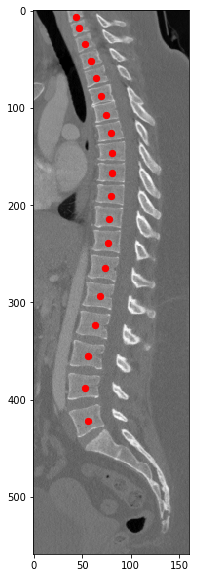

In [43]:
# Draw point
import numpy as np
import random

x_coords = []
y_coords = []
labels = []
for result in yolo_results:
    print(result)
    x_coords.append(result['center_x'])
    y_coords.append(result['center_y'])
    labels.append(result['label'])
    

plt.figure(figsize=(10, 10))
plt.imshow(x[:,:,z], cmap='gray')

for i in range(len(x_coords)):
    #color = [1, 0 + random.random()/2, 0.5 + random.random()/2]
    x_coord, y_coord, label = x_coords[i], y_coords[i], labels[i]
    plt.scatter(x = x_coord, y = y_coord, c = [1,0,0], s = 40)
    #plt.text(x_coord + 15, y_coord, label, fontsize=16, color = color)

plt.show()

In [9]:
size = 128
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import random

def setGPU():
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    #config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))
setGPU()

Using TensorFlow backend.


In [21]:

def model():
    from keras.models import Model
    from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, BatchNormalization, Activation, Dense, Flatten
    
    def conv(input_tensor, depth):
        conv_tensor = Conv3D(depth, 3, padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
        bn = BatchNormalization()(conv_tensor) # use_bias=False
        output_tensor = Activation('relu')(bn)
        return output_tensor
    
    def pool(input_tensor):
        output_tensor = MaxPooling3D(pool_size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def up(input_tensor):
        output_tensor = UpSampling3D(size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def skip(input_tensor1, input_tensor2):
        output_tensor = Concatenate(axis=-1)([input_tensor1, input_tensor2])
        return output_tensor
    
    depth = 4
    
    input_img = Input(shape=(size, size, size, 1))
    
    conv1 = conv(input_img, depth)
    conv2 = conv(conv1, depth * 2)
    
    pool1 = pool(conv2)
    
    conv3 = conv(pool1, depth * 2)
    conv4 = conv(conv3, depth * 4)
    
    pool2 = pool(conv4)
    
    conv5 = conv(pool2, depth * 4)
    conv6 = conv(conv5, depth * 8)
    
    pool3 = pool(conv6)
    
    conv7 = conv(pool3, depth * 8)
    conv8 = conv(conv7, depth * 16)   

    up1 = up(conv8)
    
    skip1 = skip(conv6, up1)
    
    conv9 = conv(skip1, depth * 8)
    conv10 = conv(conv9, depth * 8)
    
    up2   = up(conv10)
    
    skip2 = skip(conv4, up2)
    
    conv11 = conv(skip2, depth * 4)
    conv12 = conv(conv11, depth * 4)
    
    up3   = up(conv12)
    
    skip3 = skip(conv2, up3)
    
    conv13 = conv(skip3, depth * 2)
    conv14 = conv(conv13, depth * 2)    
   
    conv15 = conv(conv14, 1)

    output_img = conv15
    
    # model
    model = Model(inputs=input_img, outputs=output_img)
    print (model.output_shape)

    # optimizer
    opt = keras.optimizers.Adam(lr=1e-2)#32-5,16-3
    
    model.compile(optimizer=opt,
                  loss = 'mse',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

model = model()
model.load_weights('../segmentation/save/model.d4.weights.best.h5')

(None, 128, 128, 128, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_41 (Conv3D)              (None, 128, 128, 128 112         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 128, 128, 128 16          conv3d_41[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 128, 128, 128 0           batch_normalization_41[0][0]     
____________________________________________________________________________________

In [22]:

def model2():
    from keras.models import Model
    from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, BatchNormalization, Activation, Dense, Flatten
    
    def conv(input_tensor, depth):
        conv_tensor = Conv3D(depth, 3, padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
        bn = BatchNormalization()(conv_tensor) # use_bias=False
        output_tensor = Activation('relu')(bn)
        return output_tensor
    
    def pool(input_tensor):
        output_tensor = MaxPooling3D(pool_size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def up(input_tensor):
        output_tensor = UpSampling3D(size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def skip(input_tensor1, input_tensor2):
        output_tensor = Concatenate(axis=-1)([input_tensor1, input_tensor2])
        return output_tensor
    
    input_img = Input(shape=(size, size, size, 1))
    
    conv1 = conv(input_img, 8)
    conv2 = conv(conv1, 8)
    
    pool1 = pool(conv2)
    
    conv3 = conv(pool1, 16)
    conv4 = conv(conv3, 16)
    
    pool2 = pool(conv4)
    
    conv5 = conv(pool2, 32)
    conv6 = conv(conv5, 32)
    
    pool3 = pool(conv6)
    
    conv7 = conv(pool3, 64)
    conv8 = conv(conv7, 64)

    pool4 = pool(conv8)
    
    conv9 = conv(pool4, 128)
    conv10 = conv(conv9, 128)
    
    flat = Flatten()(conv10)
    
    dense1 = Dense(units = 1024, activation = 'relu')(flat)
    
    output_cat = Dense(units = 20, activation = 'softmax')(dense1)

    
    # model
    model = Model(inputs=input_img, outputs=output_cat)
    print (model.output_shape)

    # optimizer
    opt = keras.optimizers.Adam(lr=1e-4)#32-5,16-3
    
    model.compile(optimizer=opt,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

model2 = model2()
model2.load_weights('../segmentation/save/model.label.weights.best.h5')

(None, 20)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 128, 1)  0         
_________________________________________________________________
conv3d_56 (Conv3D)           (None, 128, 128, 128, 8)  224       
_________________________________________________________________
batch_normalization_56 (Batc (None, 128, 128, 128, 8)  32        
_________________________________________________________________
activation_56 (Activation)   (None, 128, 128, 128, 8)  0         
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 128, 128, 128, 8)  1736      
_________________________________________________________________
batch_normalization_57 (Batc (None, 128, 128, 128, 8)  32        
_________________________________________________________________
activation_57 (Activation)   (None, 128, 128, 128, 8)  0         

In [45]:
def generate_seg_result(vertebrae):
    # generate segmentation test data .npy
    shape = x.shape

    #vertebrae = {'label': 'T8', 'left_x': 65, 'top_y': 154, 'center_x': 98, 'center_y': 187, 'w': 67, 'h': 67}

    center_x, center_y = vertebrae['center_x'], vertebrae['center_y']

    size = 128 # patch size = size*size*size
    min_x, max_x, min_y, max_y = center_x - size/2, center_x + size/2, center_y - size/2, center_y + size/2

    range_x = [
        int(min_x if min_x > 0 else 0),
        int(max_x if max_x < (shape[1] - 1) else (shape[1] - 1))
    ]
    range_y = [
        int(min_y if min_y > 0 else 0),
        int(max_y if max_y < (shape[0] - 1) else (shape[0] - 1))
    ]
    range_z = [
        int(z - size/2),
        int(z + size/2)
    ]
    #print(range_x)
    #print(range_y)
    #print(center_x)

    padding_y = (
    int(size/2) - center_y + range_y[0],
    int(size/2) - range_y[1] + center_y
    )
    padding_x = (
        int(size/2) - center_x + range_x[0],
        int(size/2) - range_x[1] + center_x
    )

    out_x = np.pad(
        x[
            range_y[0]: range_y[1]
            , range_x[0]: range_x[1]
            , range_z[0]: range_z[1]],
        (padding_y, padding_x, (0, 0)),
        'constant') / 255

    #plt.imshow(out_x[:,:,65], cmap='gray')
    #np.save('./tmp/seg_test_data/{}.npy'.format(vertebrae['label']), out_x)
    
    out_x = np.reshape(out_x, (1, 128, 128, 128, -1))
    
    out_y = model.predict(out_x)
    
    out_y = np.reshape(out_y, (128, 128, 128))
    
    #plt.imshow(out_y[:,:,z], cmap='gray')
    
    return out_y

In [46]:
# combine seg result

combine_result = np.zeros(x.shape)

vertebrae = {'label': 'vertebrae', 'left_x': 34, 'top_y': 373, 'center_x': 53, 'center_y': 388, 'w': 38, 'h': 30}
seg_result = generate_seg_result(vertebrae)

#plt.imshow(seg_result[:,:,z], cmap='gray')

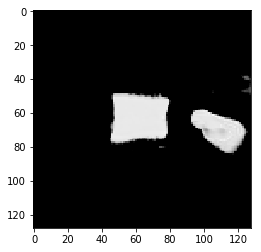

In [47]:
plt.imshow(seg_result[:,:,60], cmap='gray')

In [119]:
# combine
seg_results = np.zeros((len(yolo_results) ,size, size, size))
label_results = []

for i in range(len(yolo_results)):
    seg_result = generate_seg_result(yolo_results[i])
    #plt.imshow(seg_result[:,:,60] > 0.5, cmap='gray')
    seg_results[i] = seg_result
    
    label_result = model2.predict(np.reshape(seg_result, (1, 128, 128, 128, -1)))[0]
    label_results.append(label_result)

In [220]:
#print(label_results[17])
for i in range(len(label_results[17])):
    print('V{} \t P {}'.format(i, round(label_results[17][i], 10)))

V0 	 P 2.000000026702864e-10
V1 	 P 2.3397999484586762e-06
V2 	 P 4.877740138908848e-05
V3 	 P 0.00020583659352269024
V4 	 P 2.6519001039559953e-06
V5 	 P 0.0008612942765466869
V6 	 P 0.006486660335212946
V7 	 P 0.01296627800911665
V8 	 P 1.000000013351432e-10
V9 	 P 0.0
V10 	 P 0.0008674144046381116
V11 	 P 0.0
V12 	 P 0.010208658874034882
V13 	 P 0.0017802416114136577
V14 	 P 0.06280738115310669
V15 	 P 0.0205689650028944
V16 	 P 0.16200777888298035
V17 	 P 0.0
V18 	 P 0.6684539318084717
V19 	 P 0.05273183062672615


In [73]:
#print(label_results)
for label_result in label_results:
    print('label {} \t confidence {}'.format(np.argmax(label_result), max(label_result)))

label 2 	 confidence 0.5061994194984436
label 2 	 confidence 0.7747923135757446
label 2 	 confidence 0.4064825773239136
label 4 	 confidence 0.22175174951553345
label 5 	 confidence 0.9427841901779175
label 6 	 confidence 0.5885617136955261
label 7 	 confidence 0.6954007744789124
label 7 	 confidence 0.986454963684082
label 7 	 confidence 0.7203847169876099
label 10 	 confidence 0.9881503582000732
label 12 	 confidence 0.31475314497947693
label 12 	 confidence 0.5092918276786804
label 13 	 confidence 0.3496726453304291
label 14 	 confidence 0.5551480054855347
label 15 	 confidence 0.8591744303703308
label 15 	 confidence 0.6432157158851624
label 16 	 confidence 0.354060560464859
label 18 	 confidence 0.6684539318084717
label 19 	 confidence 0.9998378753662109


In [96]:
n_of_vertebrae = len(yolo_results)
confidences = [] # conf of labels start from


for i in range(20): # label start from
    sum_of_confidences = 0
    for n in range(n_of_vertebrae):
        #print(label_results[n][(i + n) % 20])
        sum_of_confidences += label_results[n][(i + n) % 20]
    #print(sum_of_confidences / 20)
    confidences.append(sum_of_confidences / 20)
    print('{} \t as head, average confidence {}'.format(i, sum_of_confidences / 20))

head = np.argmax(confidences)
print()
print('Result: choose {} as head'.format(head))
print('From {} to {}'.format(head, head + n_of_vertebrae -1))

0 	 as head, average confidence 0.18036420428867583
1 	 as head, average confidence 0.44162956589962554
2 	 as head, average confidence 0.10002522844693522
3 	 as head, average confidence 0.015075628878776351
4 	 as head, average confidence 0.010720208987403276
5 	 as head, average confidence 0.014729283459643912
6 	 as head, average confidence 0.011430672841716113
7 	 as head, average confidence 0.013815727824945187
8 	 as head, average confidence 0.004867075252880587
9 	 as head, average confidence 0.0033778215692374528
10 	 as head, average confidence 0.004492763002552793
11 	 as head, average confidence 0.0033558886485962774
12 	 as head, average confidence 0.008791586193404321
13 	 as head, average confidence 0.008174570119050524
14 	 as head, average confidence 0.0031122285642913488
15 	 as head, average confidence 0.008927030501638376
16 	 as head, average confidence 0.008960795850094566
17 	 as head, average confidence 0.013529583068234046
18 	 as head, average confidence 0.015

In [203]:
# generate final result
# (559, 160, 160)
import random

final_result = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size)) # 64 padding
final_result_colored = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size, 3)) # colored

for i in range(len(yolo_results)):
    
    x_start = yolo_results[i]['center_x'] - 64 + 64
    x_end = yolo_results[i]['center_x'] + 64 + 64
    
    y_start = yolo_results[i]['center_y'] - 64 + 64
    y_end = yolo_results[i]['center_y'] + 64 + 64
    
    result = np.zeros((x.shape[0] + size, x.shape[1] + size, x.shape[2] + size))
    result[y_start:y_end, x_start:x_end, (z - 64 + 64):(z + 64 + 64)] = seg_results[i][:, :, :] > 0.5 # (y, x, z)
    
    final_result[np.where(result > 0.5)] = 1
    final_result_colored[np.where(result > 0.5)] = [
        random.random()/2 + 0.5,
        random.random()/2 + 0.5,
        random.random()/2 + 0.5]
    
#     for p in range(0, size):
#         for q in range(0, size):
#             for r in range(0, size):
#                 if seg_results[i][p, q, r] > 0.5:
#                     final_result[p + 64, q + 64, r + 64] = 1
    
final_result = final_result[
    int(size/2): x.shape[0] + int(size/2),
    int(size/2): x.shape[1] + int(size/2),
    int(size/2): x.shape[2] + int(size/2)]
final_result_colored = final_result_colored[
    int(size/2): x.shape[0] + int(size/2),
    int(size/2): x.shape[1] + int(size/2),
    int(size/2): x.shape[2] + int(size/2)]

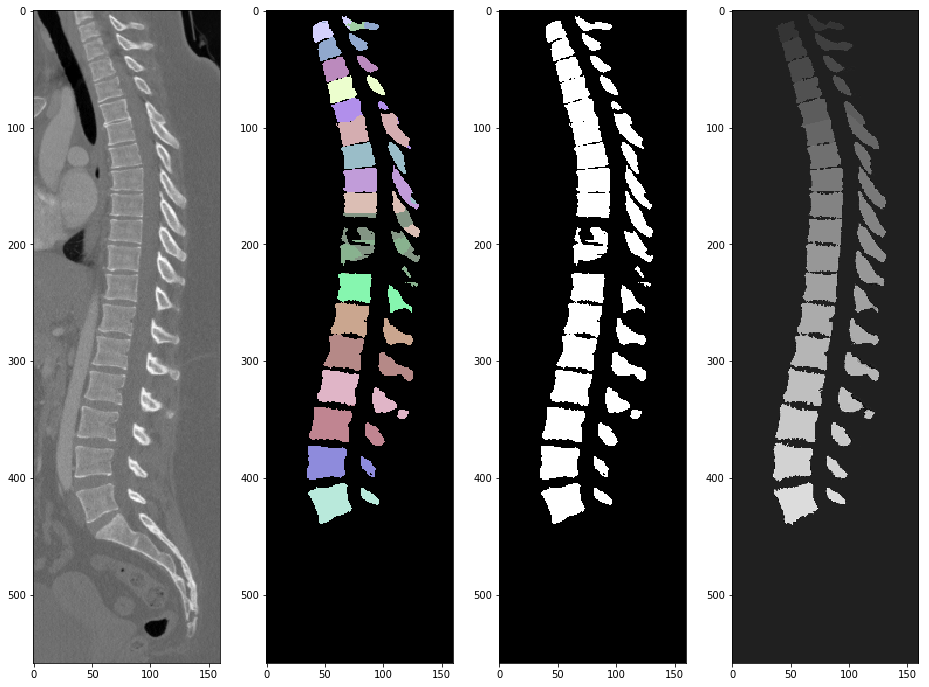

In [209]:
plt.figure(figsize=(16, 12))
plt.subplot(141)
plt.imshow(x[:,:,z], cmap='gray')
plt.subplot(142)
plt.imshow(final_result_colored[:,:,z,:])
plt.subplot(143)
plt.imshow(final_result[:,:,z], cmap='gray')
plt.subplot(144)
plt.imshow(y[:,:,z], cmap='gray')

In [222]:
for i in range(x.shape[2]):
    cv2.imwrite('./show/{}.png'.format(i), final_result[:,:,i] * 255)